In [62]:
import torch

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2

from model import ProjectionNet
from dataset import MVTecAT

### CAM on trained model for bottle

#### Load dataset

In [48]:
size = 256
test_transform = transforms.Compose([])
test_transform.transforms.append(transforms.Resize((size,size)))
test_transform.transforms.append(transforms.ToTensor())
test_transform.transforms.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225]))
test_data_eval = MVTecAT("Data", "bottle", size, transform = test_transform, mode="test")
dataloader_test = DataLoader(test_data_eval, batch_size=64,
                                    shuffle=False, num_workers=0)


vis_transform = transforms.Compose([])
vis_transform.transforms.append(transforms.Resize((size,size)))
vis_transform.transforms.append(transforms.ToTensor())

vis_data_eval = MVTecAT("Data", "bottle", size, transform = vis_transform, mode="test")
dataloader_vis = DataLoader(vis_data_eval, batch_size=64,
                                    shuffle=False, num_workers=0)


    

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### load models

In [31]:
device="cuda"
weights = torch.load("models/model-bottle-2023-07-08_23_17_41.tch")
head_layer = 2
head_layers = [512]*head_layer+[128]
classes = weights["out.weight"].shape[0]
print(f"classes: {classes}")
model = ProjectionNet(pretrained=True, head_layers=head_layers, num_classes=classes)
model.load_state_dict(weights)
model.to(device)
model.eval()

classes: 3


/home/ubuntu/pytorch-cutpaste/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/pytorch-cutpaste/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ProjectionNet(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [50]:
input_tensor, labels = next(iter(dataloader_test))

tensor(2.6400)

In [49]:
vis_input_tensor, labels = next(iter(dataloader_vis))
in_np = vis_input_tensor.cpu().detach().numpy()
print(in_np.shape, in_np[0].min(), in_np[1].max())
# in_np = np.moveaxis(in_np, 1, 3)
# print(in_np.shape)
# # np.rollaxis(input_tensor[0], 1, 3).shape
# ch_last = input_tensor[0].permute(0, 2, 1)
# print(ch_last.shape)
# plt.imshow(in_np)

(64, 3, 256, 256) 0.10980392 1.0


In [42]:
model.forward(input_tensor.to(device))[1].shape

torch.Size([64, 3])

In [43]:
np.argmax(model.forward(input_tensor.to(device))[1].cpu().data.numpy(), axis=-1)

array([1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1])

In [56]:
%reload_ext autoreload

target_layers = [model.resnet18.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(2)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.

grayscale_cam = cam(input_tensor=input_tensor, targets=None)
grayscale_cam = grayscale_cam[3, :]
in_np = vis_input_tensor[3].cpu().detach().numpy()
in_np = np.moveaxis(in_np, 0, 2)
visualization = show_cam_on_image(in_np, grayscale_cam, use_rgb=True)

outputs torch.Size([64, 3])
loss torch.Size([]): 376.78240966796875
getting target size
target size got, (256, 256)
inside CAM for loop
================get_cam_image=====================
input_tensor:  torch.Size([64, 3, 256, 256])
targets:  64
layer_activations:  (64, 512, 8, 8)
layer_grads:  (64, 512, 8, 8)
afte CAM for loop


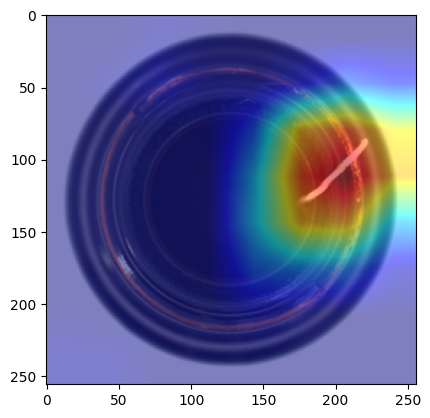

In [57]:
plt.imshow(visualization)

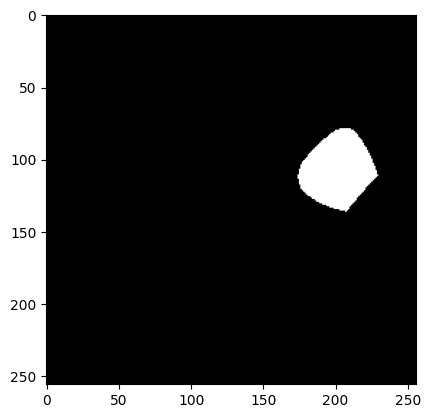

In [71]:

grayscale_cam.shape
normalizedImg = np.zeros((256, 256))
normalizedImg = cv2.normalize(grayscale_cam,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
(T, threshInv) = cv2.threshold(normalizedImg, 200, 255,cv2.THRESH_BINARY)
plt.imshow(threshInv, cmap='gray')

In [13]:
for x, label in dataloader_test:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=True)

AttributeError: 'tuple' object has no attribute 'shape'

In [10]:
%reload_ext autoreload

import argparse
import cv2
import numpy as np
import torch
import timm

from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit


# def get_args():
#     # parser = argparse.ArgumentParser()
#     # parser.add_argument('--use-cuda', action='store_true', default=True,
#     #                     help='Use NVIDIA GPU acceleration')
#     # parser.add_argument(
#     #     '--image-path',
#     #     type=str,
#     #     default='./both.png',
#     #     help='Input image path')
#     # parser.add_argument('--aug_smooth', action='store_true',
#     #                     help='Apply test time augmentation to smooth the CAM')
#     # parser.add_argument(
#     #     '--eigen_smooth',
#     #     action='store_true',
#     #     help='Reduce noise by taking the first principle componenet'
#     #     'of cam_weights*activations')

#     # parser.add_argument(
#     #     '--method',
#     #     type=str,
#     #     default='gradcam',
#     #     help='Can be gradcam/gradcam++/scorecam/xgradcam/ablationcam')

#     args = parser.parse_args()
#     # args.use_cuda = args.use_cuda and torch.cuda.is_available()
#     if args.use_cuda:
#         print('Using GPU for acceleration')
#     else:
#         print('Using CPU for computation')

#     return args


def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


# if __name__ == '__main__':
    """ python swinT_example.py -image-path <path_to_image>
    Example usage of using cam-methods on a SwinTransformers network.

    """

# args = get_args()

use_cuda = True
method = "gradcam"
image_path = "./both.png"
aug_smooth = False
eigen_smooth = False

methods = {"gradcam": GradCAM}

if method not in list(methods.keys()):
    raise Exception(f"method should be one of {list(methods.keys())}")

model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
model.eval()

if use_cuda:
    model = model.cuda()

target_layers = [model.layers[-1].blocks[-1].norm2]

if method not in methods:
    raise Exception(f"Method {method} not implemented")

if method == "ablationcam":
    cam = methods[method](model=model,
                                target_layers=target_layers,
                                use_cuda=use_cuda,
                                reshape_transform=reshape_transform,
                                ablation_layer=AblationLayerVit())
else:
    cam = methods[method](model=model,
                                target_layers=target_layers,
                                use_cuda=use_cuda,
                                reshape_transform=reshape_transform)


rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
print(rgb_img.shape)
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
# input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
#                                 std=[0.5, 0.5, 0.5])

print(input_tensor.shape)

# AblationCAM and ScoreCAM have batched implementations.
# You can override the internal batch size for faster computation.
cam.batch_size = 32

grayscale_cam = cam(input_tensor=input_tensor,
                    targets=None,
                    eigen_smooth=eigen_smooth,
                    aug_smooth=aug_smooth)

# Here grayscale_cam has only one image in the batch
grayscale_cam = grayscale_cam[0, :]

cam_image = show_cam_on_image(rgb_img, grayscale_cam)
cv2.imwrite(f'{method}_cam.jpg', cam_image)

(224, 224, 3)
torch.Size([64, 3, 224, 224])
outputs torch.Size([64, 1000])
loss torch.Size([]): 441.0564270019531
getting target size
target size got, (224, 224)
inside CAM for loop
================get_cam_image=====================
input_tensor:  torch.Size([64, 3, 224, 224])
targets:  64
layer_activations:  (64, 1024, 7, 7)
layer_grads:  (64, 1024, 7, 7)
afte CAM for loop


True

In [64]:
cv2.imread("./both.png", 1)[:, :, ::-1]

array([[[155, 136, 110],
        [145, 133, 106],
        [145, 130, 104],
        ...,
        [  9,  10,   5],
        [ 18,  16,  11],
        [ 26,  20,  14]],

       [[156, 137, 117],
        [150, 136, 113],
        [146, 131, 106],
        ...,
        [ 10,  11,   6],
        [ 17,  15,  10],
        [ 32,  26,  20]],

       [[157, 139, 119],
        [151, 136, 114],
        [146, 131, 108],
        ...,
        [ 10,  10,   6],
        [ 21,  19,  14],
        [ 38,  32,  26]],

       ...,

       [[229, 213, 180],
        [175, 158, 116],
        [149, 124,  94],
        ...,
        [118, 104,  90],
        [112,  97,  85],
        [113, 101,  85]],

       [[241, 225, 202],
        [233, 219, 197],
        [181, 161, 123],
        ...,
        [121, 107,  93],
        [117, 101,  90],
        [121, 110,  93]],

       [[239, 207, 185],
        [239, 211, 189],
        [234, 214, 181],
        ...,
        [116, 105,  88],
        [119, 103,  91],
        [117, 103,  90]]